In [47]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from utils import *
import re

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.python.client import device_lib

In [22]:
# Define random seed and print available devices (CPU-GPU)
np.random.seed(24)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9337444532766287648
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8794020212488526578
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Loading images

In [23]:
image_dir_train = "data/training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)
print(f"Loading training images, images loaded: {n_train} ")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)
gt_dir_train = "data/training/groundtruth/"
print(f"Loading groundtruth images, images loaded: {n_train} ")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading training images, images loaded: 100 
Loading groundtruth images, images loaded: 100 


In [24]:
image_dir_val = "data/validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)
print(f"Loading validating images, images loaded: {n_val} ")
imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])
gt_dir_val = "data/validating/groundtruth/"
print(f"Loading validating groundtruth, images loaded: {n_val} ")
gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

Loading validating images, images loaded: 20 
Loading validating groundtruth, images loaded: 20 


In [25]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [26]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [27]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(900, 448, 448, 3)
(900, 448, 448)


In [28]:
# X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [29]:
# X_val = np.asarray(X_val)
# Y_val = np.asarray(Y_val)

In [30]:
# print(X_val.shape)
# print(Y_val.shape)
# n_val = Y_val.shape[0]

# Create functions to calcualte precision, recall and F-1 in the training of model

In [31]:
def precision(y_true, y_pred):
    """Compute the Precision for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
        Precision (numpy.float64): the Precision of the batch 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Compute the Recall for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       Recall (numpy.float64): the Recal of the batch 
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    """Compute the F-1 for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       F-1 (numpy.float64): the F-1 of the batch 
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# U-Net Architecture

In [32]:
def down(input_layer, filters, pool=True):
    """Create convloutional and residual layers to reduce dimensions.
    Args:
        input_layer (layer): input layer before convolution
        filters (numpy.int64): number of filters
    Returns:
        max_pool (layer): layer after max-pooling
        residual (connection ): connection to connect with next layers
    """
    batchnorm = BatchNormalization()(input_layer)
    conv1 = Conv2D(filters, (5, 5), padding="same", activation="relu")(batchnorm)
    residual = Conv2D(filters, (3, 3), padding="same", activation="relu")(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual


def up(input_layer, residual, filters):
    """Create convloutional and residual layers to increase dimensions.
    Args:
        input_layer (layer): input layer before convolution\
        residual (connection ): connection to connect with next layers
        filters (numpy.int64): number of filters
    Returns:
        conv2 (layer): convolutional layer
    """
    filters = int(filters)
    batchnorm = BatchNormalization()(input_layer)
    upsample = UpSampling2D()(batchnorm)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (5, 5), padding="same", activation="relu")(concat)
    conv2 = Conv2D(filters, (3, 3), padding="same", activation="relu")(conv1)
    return conv2


class U_NET:
    def __init__(self, shape):
        self.shape = shape
        self.model = self.initialize_U_NET(shape)

    def initialize_U_NET(self, shape):
        """Create Network Architecture.
        Args:
            shape (triplet): Size of the input layer height x width x colors (64 x 64 x 3)
        Returns:
            model (Neural Network): Architecture of the model
        """
        # Make a custom U-nets implementation.
        filters = 64
        input_layer = Input(shape=shape)
        layers = [input_layer]
        residuals = []

        # Down 1, 64
        d1, res1 = down(input_layer, filters)
        residuals.append(res1)
        filters *= 2

        # Down 2, 32
        d2, res2 = down(d1, filters)
        residuals.append(res2)
        filters *= 2

        # Down 3, 16
        d3, res3 = down(d2, filters)
        residuals.append(res3)
        filters *= 2

        # Down 4, 8
        d4, res4 = down(d3, filters)
        residuals.append(res4)
        filters *= 2

        # Up 1, 8
        up1 = up(d4, residual=residuals[-1], filters=filters / 2)
        filters /= 2

        # Up 2,  16
        up2 = up(up1, residual=residuals[-2], filters=filters / 2)
        filters /= 2

        # Up 3, 32
        up3 = up(up2, residual=residuals[-3], filters=filters / 2)
        filters /= 2

        # Up 4, 64
        up4 = up(up3, residual=residuals[-4], filters=filters / 2)

        conv_1 = Conv2D(1, 1, activation="relu")(up4)
        flaten = Flatten()(conv_1)
        batch_1 = BatchNormalization()(flaten)
        out = Dense(
            2,
            activation="sigmoid",
            kernel_regularizer=l2(0.00001),
            activity_regularizer=l2(0.00001),
        )(batch_1)

        model = Model(input_layer, out)
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(learning_rate=0.001),
            metrics=["accuracy", recall, f1],
        )

        model.summary()

        return model

    def train(self):
        """Train the Model.

        Returns:
            History (History_Keras): History of the training
        """
        early_stopping = EarlyStopping(
            monitor="loss", patience=10, verbose=1, restore_best_weights=True,
        )

        lr_callback = ReduceLROnPlateau(
            monitor="loss", factor=0.2, patience=5, verbose=1, cooldown=1,
        )

        save_best = ModelCheckpoint(
            "Unet_batchnorm_fix-{epoch:03d}-{f1:03f}.h5",
            save_best_only=True,
            monitor="loss",
            verbose=1,
        )

        callbacks = [lr_callback, save_best, early_stopping]

        history = self.model.fit_generator(
            create_minibatch(
                X_train, Y_train, n_train, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE, WIDTH
            ),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            #             validation_data=create_minibatch(
            #                 X_val, Y_val, n_val, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE, WIDTH
            #             ),
            #             validation_steps=STEPS_PER_EPOCH / 3,
        )
        return history

    def classify(self, X):
        """Classify Image as either road or not.
        Args:
            X (image): part of the image to classify
        Returns:
            Predictions : Predictions for each patch
        """
        img_patches = create_patches(X, 16, 16, padding=24)

        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        return predictions.reshape(X.shape[0], -1)

    def load(self, filename):
        """Loads Saved Model.
        Args:
           filename (string): name of the model
           
        """
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        """Saves trained model.
        Args:
           filename (string): name of the model
           
        """
        self.model.save(filename)

In [35]:
# We define parameters of the model
BATCH_SIZE = 100
WINDOW_SIZE = 64
PATCH_SIZE = 16
EPOCHS = 200
STEPS_PER_EPOCH = 100
WIDTH = 448
model = U_NET(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 64, 64, 3)    12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 64, 64, 64)   4864        batch_normalization_27[0][0]     
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_63[0][0]                  
____________________________________________________________________________________________

# Train the Model


In [36]:
history = model.train()

Epoch 1/200
 99/100 [============================>.] - ETA: 1s - loss: 0.5257 - accuracy: 0.7414 - recall: 0.7357 - f1: 0.7383
Epoch 00001: loss improved from inf to 0.52557, saving model to Unet_batchnorm_fix-001-0.738185.h5
100/100 [==============================] - 129s 1s/step - loss: 0.5256 - accuracy: 0.7412 - recall: 0.7356 - f1: 0.7382
Epoch 2/200
 99/100 [============================>.] - ETA: 1s - loss: 0.4149 - accuracy: 0.8011 - recall: 0.8014 - f1: 0.8011
Epoch 00002: loss improved from 0.52557 to 0.41461, saving model to Unet_batchnorm_fix-002-0.801520.h5
100/100 [==============================] - 116s 1s/step - loss: 0.4146 - accuracy: 0.8015 - recall: 0.8018 - f1: 0.8015
Epoch 3/200
 99/100 [============================>.] - ETA: 1s - loss: 0.3705 - accuracy: 0.8303 - recall: 0.8310 - f1: 0.8303
Epoch 00003: loss improved from 0.41461 to 0.37022, saving model to Unet_batchnorm_fix-003-0.830402.h5
100/100 [==============================] - 118s 1s/step - loss: 0.3702 - a

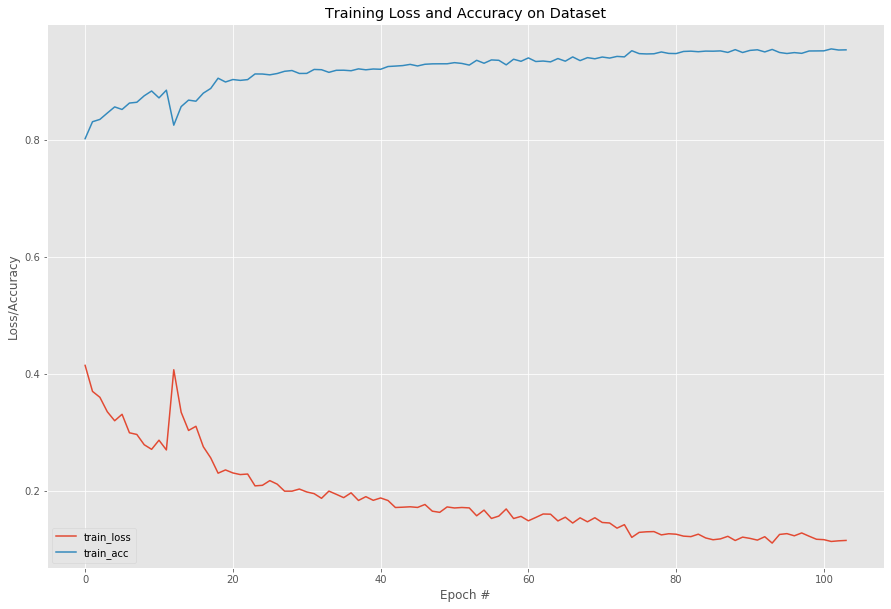

In [37]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
# plt.plot(history.history["val_loss"][1:], label="val_loss")
plt.plot(history.history["accuracy"][1:], label="train_acc")
# plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots/Unet_batchnorm_fix.pdf")
plt.show()

In [49]:
# Instantiate the model
model = U_NET(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

# Load the model
model.load("Unet_batchnorm_fix-095-0.953749.h5")

model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "Unet_batchnorm_fix-095-0.953749.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 64, 64, 3)    12          input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 64, 64, 64)   4864        batch_normalization_72[0][0]     
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 64, 64, 64)   36928       conv2d_168[0][0]                 
____________________________________________________________________________________________